In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [261]:
# === Utilidades ===
def exp_reward(value, setpoint, scaled, weight):
    return float(weight) * np.exp(-((value - setpoint) / float(scaled))**2)

def tanh_target(error, y_max, strength):
    # error = x_sp - x  (o)  theta_sp - theta
    return float(y_max) * np.tanh(float(strength) * error)

# Incentives Rewards

In [264]:
def heatmap_total_with_band(block, x_sp, savefigure):
    # malla
    e = np.linspace(block["e_range"][0], block["e_range"][1], 400) # error: x_sp - x, o theta_sp - theta
    y = np.linspace(block["y_range"][0], block["y_range"][1], 400) # valor de la variable objetivo
    E, Y = np.meshgrid(e, y)
    # Target y recompensa de seguimiento
    T = block["y_max"] * np.tanh(block["strength"] * E)
    R_track = 0.0
    if block["track_scaled"] is not None and block["track_weight"] > 0.0:
        R_track = block["track_weight"] * np.exp(-((Y - T) / block["track_scaled"]) ** 2)
    # recompensa base (si aplica)
    R_base = 0.0
    if block["base_scaled"] is not None and block["base_weight"] > 0.0:
        R_base = block["base_weight"] * np.exp(-((Y - block["base_setpoint"]) / block["base_scaled"]) ** 2)
    # bonus de banda
    y_low, y_high = BAND_RANGES[block["name"]]
    R_band = np.where((Y >= y_low) & (Y <= y_high), PER_STEP_BAND_BONUS, 0.0)
    # total
    R_total = R_track + R_base + R_band

    # plot
    plt.figure(figsize=(8, 5))
    plt.imshow(R_total, extent=[block["e_range"][0], block["e_range"][1], block["y_range"][0], block["y_range"][1]],
               origin='lower', aspect='auto')
    plt.colorbar(label="Incentive rewards per step")
    # curva objetivo
    e_line = np.linspace(block["e_range"][0], block["e_range"][1], 600)
    t_line = block["y_max"] * np.tanh(block["strength"] * e_line)
    plt.plot(e_line, t_line, linestyle='--', linewidth=2)
    # límites ±y_max
    plt.hlines([+block["y_max"], -block["y_max"]], block["e_range"][0], block["e_range"][1], linestyles=':', linewidth=1)
    # franja de banda
    plt.axhspan(y_low, y_high, alpha=0.15)
    # anotación breve
    plt.title(f"Total Incentive Rewards (tracking + base + banda {PER_STEP_BAND_BONUS}/step) - {block['name']}")
    plt.xlabel(block["x_label"])
    plt.ylabel(block["y_label"])
    #plt.grid()
    plt.tight_layout()
    if savefigure is True:
        plt.savefig(f"rewardMap_cartsp{x_sp}_{block['name']}.png", dpi=300)
    plt.show()

,block,depends_on,y_max,strength,track_weight,track_scaled,base_weight,base_scaled,base_setpoint,band_low,band_high,band_bonus_per_step
0,pendulum_angle,cart_position,0.12,10.0,0.25,0.05,0.6,0.06,0.0,-0.04,0.04,0.1
1,pendulum_velocity,pendulum_angle,0.50,8.0,0.10,0.25,0.2,0.30,0.0,-0.10,0.10,0.1
2,cart_velocity,cart_position,0.80,3.0,0.15,0.40,0.1,0.60,0.0,-0.20,0.20,0.1
3,cart_position,none,NaN,5.0,0.20,NaN,0.6,0.25,1.0,0.85,1.15,0.1


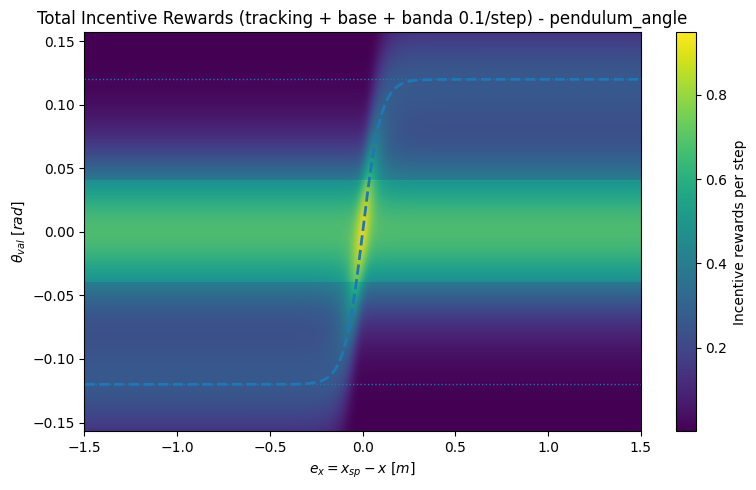

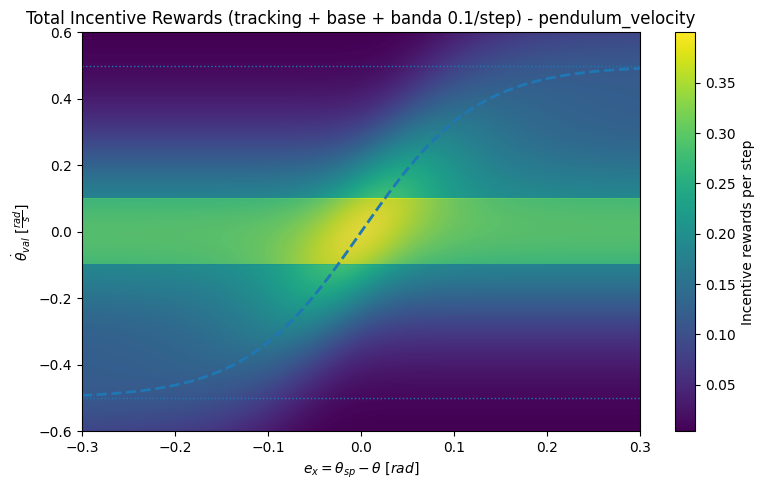

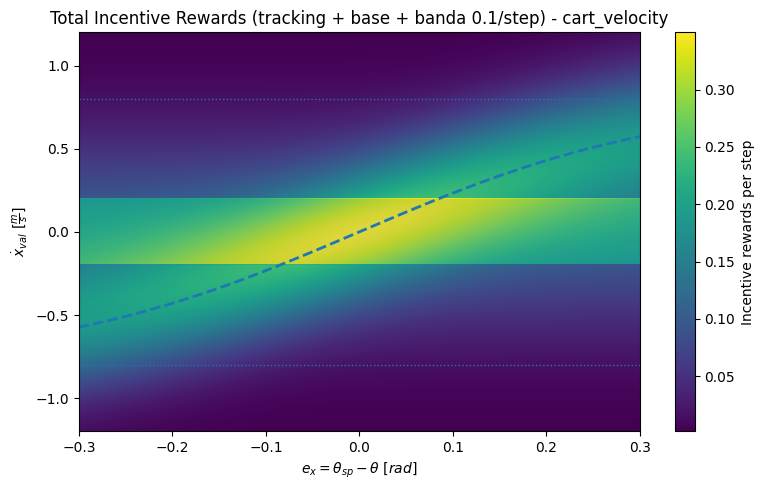

In [266]:
# === SETPOINT OBJETIVO ===
X_SP = 1.0

# === Banda (bono por paso dentro de rangos) ===
BAND_HALF_WIDTH_X = 0.15     # ±10 cm alrededor del setpoint

PER_STEP_BAND_BONUS = 0.10
BAND_RANGES = {
    "cart_position": (X_SP - BAND_HALF_WIDTH_X, X_SP + BAND_HALF_WIDTH_X),
    "cart_velocity": (-0.2, 0.2),
    "pendulum_angle": (-0.04, 0.04),
    "pendulum_velocity": (-0.1, 0.1),
}

# ---------- Bloques (sp = 0) ---------- #
block_theta_from_x = {
    "name": "pendulum_angle",
    "x_label": r"$e_x = x_{sp} - x\ [m]$",
    "y_label": r"$\theta_{val}\ [rad]$",
    "e_range": (-1.5, 1.5),
    "y_range": (-0.157, 0.157),
    "y_max": 0.12, "strength": 10.0,
    "track_scaled": 0.05, "track_weight": 0.25,
    "base_scaled": 0.06, "base_weight": 0.6, "base_setpoint": 0.0,
    "depends_on": "cart_position"
}
block_thetadot_from_theta = {
    "name": "pendulum_velocity",
    "x_label": r"$e_x = \theta_{sp} - \theta\ [rad]$",
    "y_label": r"$\dot{\theta}_{val}\ [\frac{rad}{s}]$",
    "e_range": (-0.3, 0.3),
    "y_range": (-0.6, 0.6),
    "y_max": 0.5, "strength": 8.0,
    "track_scaled": 0.25, "track_weight": 0.1,
    "base_scaled": 0.3, "base_weight": 0.2, "base_setpoint": 0.0,
    "depends_on": "pendulum_angle"
}
block_xdot_from_theta = {
    "name": "cart_velocity",
    "x_label": r"$e_x = \theta_{sp} - \theta\ [rad]$",
    "y_label": r"$\dot{x}_{val}\ [\frac{m}{s}]$",
    "e_range": (-0.3, 0.3),
    "y_range": (-1.2, 1.2),
    "y_max": 0.8, "strength": 3.0,
    "track_scaled": 0.4, "track_weight": 0.15,
    "base_scaled": 0.6, "base_weight": 0.1, "base_setpoint": 0.0,
    "depends_on": "cart_position"
}
block_x = {
    "name": "cart_position",
    "x_label": r"$e_x = x_{sp} - x\ [m]$",
    "y_label": r"$x_{val}\ [m]$",
    "e_range": (-1.2, 1.2),
    "y_range": (-1.2, 1.2),
    "y_max": None, "strength": 5.0,
    "track_scaled": None, "track_weight": 0.2,
    "base_scaled": 0.25, "base_weight": 0.6, "base_setpoint": 1.0,
    "depends_on": "none"
}

blocks = [block_theta_from_x, block_thetadot_from_theta, block_xdot_from_theta, block_x]

# Tabla resumen
rows = []
for b in blocks:
    rows.append({
        "block": b["name"],
        "depends_on": b["depends_on"],
        "y_max": b["y_max"],
        "strength": b["strength"],
        "track_weight": b["track_weight"],
        "track_scaled": b["track_scaled"],
        "base_weight": b["base_weight"],
        "base_scaled": b["base_scaled"],
        "base_setpoint": b["base_setpoint"],
        "band_low": BAND_RANGES[b["name"]][0],
        "band_high": BAND_RANGES[b["name"]][1],
        "band_bonus_per_step": PER_STEP_BAND_BONUS
    })
df = pd.DataFrame(rows)
df

# Generar 4 gráficos (solo total con banda incluida)
for b in blocks[:-1]:
    heatmap_total_with_band(b, X_SP, savefigure=False)

# Profile of Total Rewards

In [202]:
def total_reward_for_slice(block, y_vals, e_slices=None, savefigure=False, plus_band=True):
    if e_slices is None:
        e_slices = [-1.0, -0.5, 0.0, 0.5, 1.0]
    y_low, y_high = BAND_RANGES[block["name"]]
    
    plt.figure(figsize=(8, 5))
    for e_val in e_slices:
        # Tracking
        R_track = 0.0
        if block["track_scaled"] is not None and block["track_weight"] > 0.0:
            target = block["y_max"] * np.tanh(block["strength"] * e_val)
            R_track = block["track_weight"] * np.exp(-((y_vals - target) / block["track_scaled"]) ** 2)
        # Base
        R_base = 0.0
        if block["base_scaled"] is not None and block["base_weight"] > 0.0:
            R_base = block["base_weight"] * np.exp(-((y_vals - block["base_setpoint"]) / block["base_scaled"]) ** 2)
        # Band bonus
        band_low, band_high = BAND_RANGES[block["name"]]
        R_band = np.where((y_vals >= y_low) & (y_vals <= y_high), PER_STEP_BAND_BONUS, 0.0)
        if plus_band is True:
            # Recompensa total
            R_total = R_track + R_base + R_band
            # Gráficos
            e_lbl = r"e_x"
            lbl = f"t+b+b | {e_lbl}={e_val:g}" if block["track_scaled"] is not None else "b+b"
            plt.plot(y_vals, R_total, label=lbl)
        else:
            # Recompensa total
            R_total = R_track + R_base
            # Gráficos
            e_lbl = r"e_x"
            lbl = f"t+b | {e_lbl}={e_val:g}" if block["track_scaled"] is not None else "b"
            plt.plot(y_vals, R_total, label=lbl)
    
    if plus_band is True:
        plt.axvspan(y_low, y_high, alpha=0.12)
    plt.title(f"Total Reward Profiles — {block['name']}")
    plt.xlabel(block["y_label"])
    plt.ylabel("Total Reward per Step")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if savefigure is True:
        plt.savefig(f"rewardProfile_cartsp{x_sp}_{block['name']}.png", dpi=300)
    plt.show()

# Profile Total Rewards

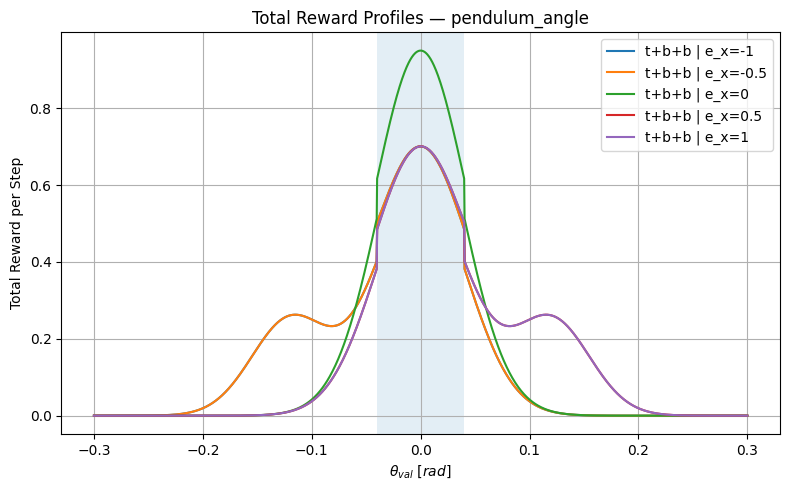

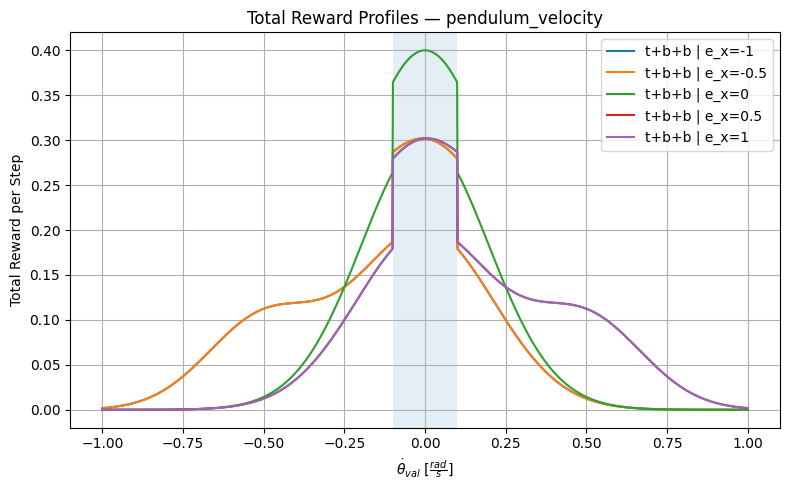

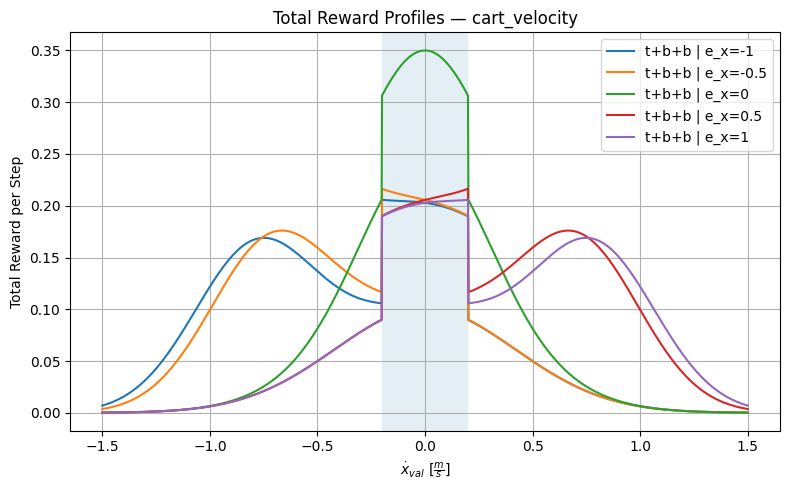

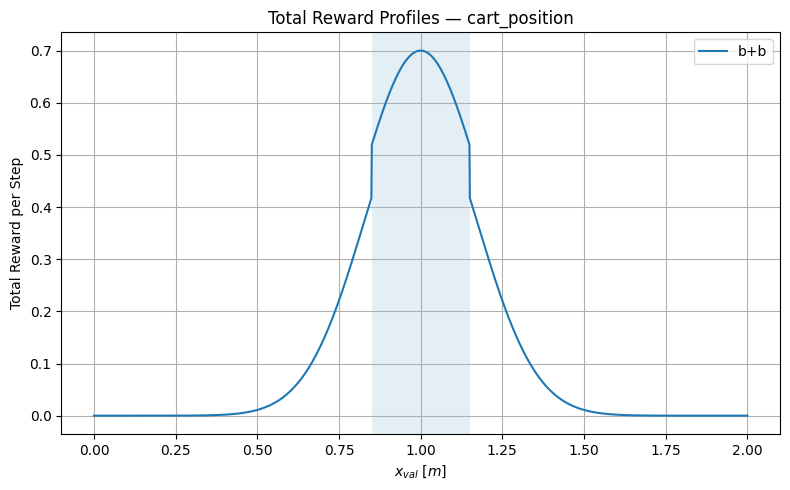

In [271]:
# Parameters
y_vals_theta = np.linspace(-0.3, 0.3, 1600)
y_vals_thetadot = np.linspace(-1.0, 1.0, 1600)
y_vals_xdot = np.linspace(-1.5, 1.5, 1600)
y_vals_x = np.linspace(0.0, 2.0, 1600)
e_slices = [-1.0, -0.5, 0.0, 0.5, 1.0]
e_slices_x = [0.0]
savefigure = False
plus_band = True
# Generar gráfico theta
total_reward_for_slice(blocks[0], y_vals_theta, e_slices, savefigure, plus_band)
# Generar gráfico thetadot
total_reward_for_slice(blocks[1], y_vals_thetadot, e_slices, savefigure, plus_band)
# Generar gráfico xdot
total_reward_for_slice(blocks[2], y_vals_xdot, e_slices, savefigure, plus_band)
# Generar gráfico x
total_reward_for_slice(blocks[3], y_vals_x, e_slices_x, savefigure, plus_band)

# Penalty Rewards

In [238]:
def plot_penalty_heatmap(var_name, cond_feature, setpoint, scaled, weight,
                         x_label, x_range, y_label, y_range, title,
                         method='quadratic'):
    xs = np.linspace(x_range[0], x_range[1], 400)
    ys = np.linspace(y_range[0], y_range[1], 400)
    X, Y = np.meshgrid(xs, ys)

    # multiplicador condicional (0..1] en función de la variable condicional (eje Y)
    mult = np.exp(-((Y - setpoint) / scaled)**2)

    # penalización base sobre la variable penalizada (eje X)
    if str(method).lower().startswith('line'):
        base_pen = -weight * np.abs(X)
    else:  # 'quadratic' por defecto
        base_pen = -weight * (X**2)

    Z = base_pen * mult  # penalización efectiva

    plt.figure(figsize=(8, 5))
    plt.imshow(Z, extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
               origin='lower', aspect='auto')
    plt.colorbar(label="Penalty")
    # guías
    plt.axhline(setpoint, linestyle=':', linewidth=1)
    plt.axvline(0.0, linestyle=':', linewidth=1)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

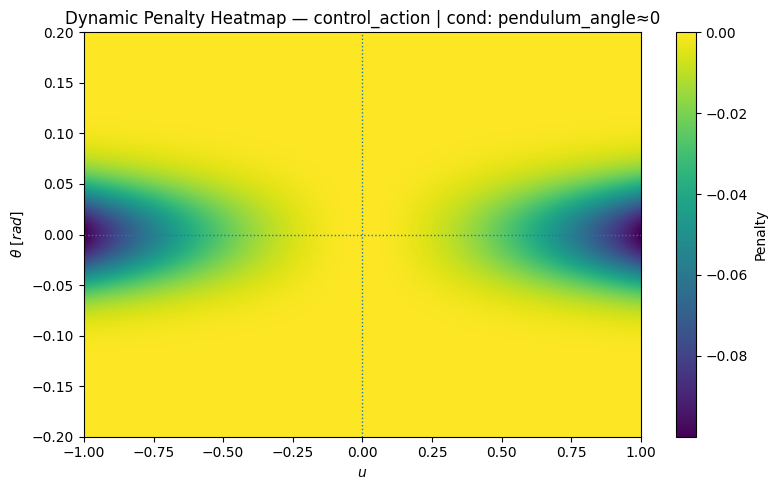

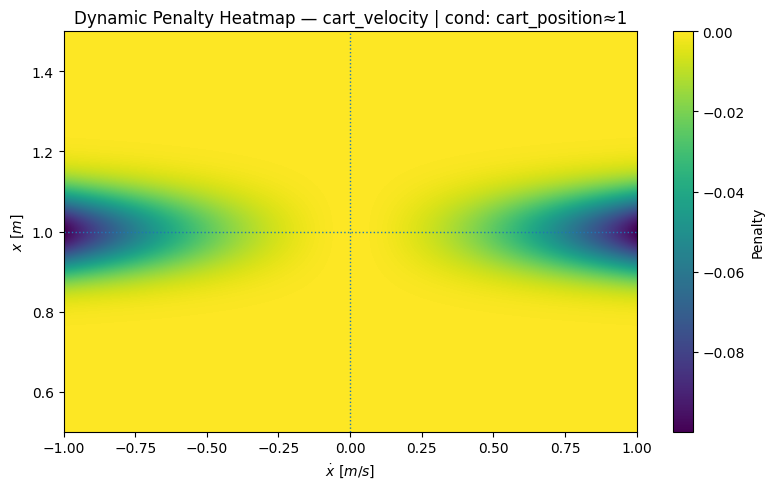

In [246]:
# Método base de penalización (visualización): 'quadratic' o 'linear'
DP_METHOD = 'quadratic'

# Penalizaciones dinámicas (declaración explícita aquí)
# Usa X_SP ya definido en el notebook.
dyn_penalties = [
    # Penaliza la acción de control cuando el péndulo está cerca de vertical (reduce tembleque)
    {"var": "control_action", "weight": 0.1,
     "condition": {"feature": "pendulum_angle", "setpoint": 0.0, "scaled": 0.05}},
    # Penaliza la velocidad del carro cuando la posición del carro está cerca de X_SP (fija el carro)
    {"var": "cart_velocity", "weight": 0.1,
     "condition": {"feature": "cart_position", "setpoint": X_SP, "scaled": 0.1}},
]

# Rango y etiquetas para ejes (mantén nombres)
_penalty_axis_cfg = {
    "pendulum_angle":    {"x_label": r"$\theta\ [rad]$",        "x_range": (-0.20, 0.20)},
    "pendulum_velocity": {"x_label": r"$\dot{\theta}\ [rad/s]$", "x_range": (-0.7, 0.7)},
    "cart_position":     {"x_label": r"$x\ [m]$",               "x_range": (0.5, 1.5)},
    "cart_velocity":     {"x_label": r"$\dot{x}\ [m/s]$",       "x_range": (-1.0, 1.0)},
    "control_action":    {"x_label": r"$u$",                    "x_range": (-1.0, 1.0)},
}

for p in dyn_penalties:
    var_name = p["var"]                      # X: variable penalizada
    weight   = p["weight"]
    cond     = p["condition"]
    feat     = cond["feature"]               # Y: variable condicional
    sp       = cond["setpoint"]
    sc       = cond["scaled"]

    xcfg = _penalty_axis_cfg.get(var_name, {"x_label": var_name, "x_range": (-1, 1)})
    ycfg = _penalty_axis_cfg.get(feat,     {"x_label": feat,     "x_range": (-1, 1)})

    title = f"Dynamic Penalty Heatmap — {var_name} | cond: {feat}≈{sp:g}"
    plot_penalty_heatmap(
        var_name=var_name,
        cond_feature=feat,
        setpoint=sp,
        scaled=sc,
        weight=weight,
        x_label=xcfg["x_label"],     # eje X = variable penalizada
        x_range=xcfg["x_range"],
        y_label=ycfg["x_label"],     # eje Y = variable condicional
        y_range=ycfg["x_range"],
        title=title,
        method=DP_METHOD
    )

# TIPS
En cualquier gaussiana $\exp(- (\frac{err}{σ})^2)$, a $|err| = σ$ el valor cae a ~$36.8\%$ del máximo; a $2σ$ cae a ~$1.8\%$.